In [28]:
# Necesarry libs

%pylab inline

import pandas as pd

# natural language toolkit
import nltk
from nltk.tokenize import word_tokenize

# transformers/classifiers
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import  ComplementNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier

#model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler, Binarizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold, SelectFromModel, mutual_info_classif

# metrics
from sklearn.metrics import accuracy_score

# plotting
from sklearn.model_selection import learning_curve
import seaborn as sns

import string
from pprint import pprint
from tempfile import TemporaryDirectory

Populating the interactive namespace from numpy and matplotlib


In [29]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

PATH_TO_DATA = './simplesentiment/'

import os
for dirname, _, filenames in os.walk(PATH_TO_DATA):
    for filename in filenames:
        print((os.path.join(dirname, filename)))

./simplesentiment/products_sentiment_train.tsv
./simplesentiment/products_sentiment_sample_submission.csv
./simplesentiment/products_sentiment_test.tsv


In [30]:
# load data

files = ['products_sentiment_train.tsv', 'products_sentiment_test.tsv']

train =  pd.read_csv(PATH_TO_DATA+files[0], sep = '\t', header = None, names = ['text', 'target'])

# train, taget, test
X = train.text
y = train.target

In [31]:
# vectorizer

from nltk.tokenize.casual import casual_tokenize
vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    #     min_df = 2,
    tokenizer=casual_tokenize,
    stop_words=None,
    #     max_df = 0.9,
    binary=True)

tfidf = TfidfTransformer(use_idf=True, sublinear_tf=False, smooth_idf=True)

preprocessing = Pipeline(steps=[
    ('v', vectorizer),
    ('tf', tfidf),
])

In [32]:
# pos/neg centroids
def get_class_diff_vector(train, target):
    mask = (target == 1).values
    pos = train[mask]
    neg = train[~mask]
    # pos/neg centroids
    pos_centroid = pos.mean(axis=0)
    neg_centroid = neg.mean(axis=0)
    return pos_centroid - neg_centroid

In [33]:
# scores to classes
def get_scores(train, target, pos_direction):
    score = train.dot(pos_direction.T)
    # scale score to [0..1]
    lda_score = RobustScaler().fit_transform(score)
    # sigmoid score
    return 1.0/(1.0 + np.exp(-lda_score))
#     return lda_score

In [34]:
# split data
def split_data(X, y, rs):
    test_portion = 0.40
    return train_test_split(X,
                            y,
                            test_size=test_portion,
                            random_state=int(rs),
                            shuffle=True,
                            stratify=y)

# data transformation
def transform_data(train, validation):
    vectorizer.fit(train)
    return vectorizer.transform(train), vectorizer.transform(validation)

In [35]:
# train score
def get_lda_param(X, y, rs):
    X_train, X_val, y_train, y_val = split_data(X, y, rs)
    Xt_train, Xt_val = transform_data(X_train, X_val)
    
    pos_direction = get_class_diff_vector(Xt_train, y_train)
    
    lda_score = get_scores(Xt_val, y_val, pos_direction).T[0]
    target = y_val.values

    ts = np.linspace(0.0, 1.0, 1001)
    accuracies = []
    for t in ts:
        lda_predict = (lda_score > t).astype(int)
        accuracies.append(accuracy_score(target, lda_predict))
    
    return np.max(accuracies), ts[np.argmax(accuracies)]

In [36]:
%%time

import warnings
warnings.filterwarnings("ignore")

results = []
rss = np.linspace(1,100, 100).astype(int)
for rs in rss:
    X_train, X_val, y_train, y_val = split_data(X, y, rs)
    train_score, t  = get_lda_param(X_train, y_train, rs)
    results.append((train_score, t, rs))

CPU times: user 42.3 s, sys: 3.83 ms, total: 42.3 s
Wall time: 42.3 s


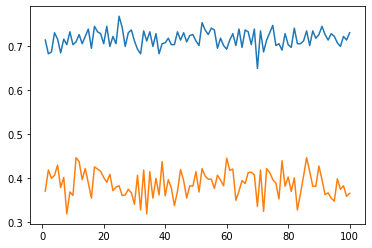

In [37]:
train_scores, ts  = [x[0] for x in results], [x[1] for x in results]
plt.plot(rss, train_scores)
plt.plot(rss, ts)

In [38]:
np.mean(train_scores), np.std(train_scores), np.median(ts), np.std(ts)

(0.7173750000000001, 0.01902625196639866, 0.39, 0.029903237282943133)

In [39]:
def accuracy_lda(X, y, vector, t0):
    lda_score = get_scores(X, y, vector).T[0]
    predictions = (lda_score > t0).astype(int)
    return accuracy_score(y, predictions)

In [40]:
random_number = 11
X_train, X_val, y_train, y_val = split_data(X, y, random_number)
Xt_train, Xt_val = transform_data(X_train, X_val)


pos_direction = get_class_diff_vector(Xt_train, y_train)

# train score
print(accuracy_lda(Xt_val, y_val, pos_direction, t0=0.4))

0.73125


In [41]:
Xt = vectorizer.fit_transform(X)
pos_direction = get_class_diff_vector(Xt, y)
print(accuracy_lda(Xt, y, pos_direction, t0 = 0.4))

0.752
